<img src="https://docs.dask.org/en/latest/_images/dask_horizontal.svg" align="right" width="30%" alt="Dask logo">


In [16]:
import warnings

# Suprimir todos los warnings
warnings.filterwarnings('ignore')

# Dask DataFrame - Parallelized pandas

It looks and feels like the pandas API, but for parallel and distributed workflows.

At its core, the `dask.dataframe` module implements a "blocked parallel" `DataFrame` object that looks and feels like the pandas API, but for parallel and distributed workflows. A Dask `DataFrame` consists of many in-memory pandas `DataFrame`s separated along the index. An operation on a Dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that accounts for potential parallelism and memory constraints.


<img src="https://docs.dask.org/en/stable/_images/dask-dataframe.svg"
     align="right"
     width="30%"
     alt="Dask DataFrame is composed of pandas DataFrames"/>

## When to Use `dask.dataframe`

Pandas is great for tabular datasets that fit into memory. A general rule of thumb for pandas is:

> "Have 5 to 10 times more RAM than the size of your dataset."
>
> ~ Wes McKinney (2017) in [10 Things I Hate About Pandas](https://wesmckinney.com/blog/apache-arrow-pandas-internals/)

Here, "dataset size" means the size of the dataset on _disk_.

Dask becomes useful when datasets exceed the above rule.

In this notebook, you will work with New York City airline data. This dataset is only ~200 MB, so you can download it in a reasonable time, but `dask.dataframe` will scale to datasets **much** larger than memory.


## Create Dataset

In [17]:
%run prep.py -d flights

## Set Up Your Local Cluster

In [18]:
from dask.distributed import Client

client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50213,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:50226,Total threads: 3
Dashboard: http://127.0.0.1:50230/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:50216,


## Read and Work with the Dataset

Let's read a subset of flights in the U.S. over several years. This data is specific to flights from the three airports in the New York City area.


In [1]:
import os
import dask

In [2]:
import dask.dataframe as dd
# Especifica los tipos de datos manualmente
dtype = {'CRSElapsedTime': 'float64', 'TailNum': 'object'}

# Lee el CSV con los tipos de datos y las fechas especificadas
ddf = dd.read_csv(
    os.path.join("data", "nycflights", "*.csv"), 
    parse_dates={"Date": [0, 1, 2]}, 
#    dtype=dtype
)

ddf

/Users/humbertofariasaroca/miniforge3/envs/data_analysis/lib/python3.12/site-packages/dask/dataframe/io/csv.py:640: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs)


,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,string,int64,float64,float64,int64,float64,float64,float64,string,string,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Dask has not yet loaded the data, it has only:
- examined the input path and discovered that there are ten matching files
- intelligently created a set of tasks for each chunk, one per original CSV file in this case


Note that the `DataFrame` object representation does not contain data: Dask has just done enough to read the beginning of the first file and infer the column names and data types.


### Lazy Evaluation

Most Dask collections, including Dask `DataFrame`, are evaluated `lazily`, which means that Dask constructs the logic (called a task graph) of your computation immediately but only "evaluates" them when necessary. You can view this task graph using `.visualize()`.

Note that we need to call `.compute()` to trigger the actual computations.


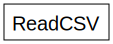

In [3]:
ddf.visualize()

Some functions like `len` and `head` also trigger a computation. Specifically, calling `len` will do the following:
- Load real data (i.e., load each file into a pandas DataFrame)
- Then apply the corresponding functions to each pandas DataFrame (also known as a partition)
- Combine the subtotals to get the final overall total


In [4]:
# cargar y contar el número de filas
len(ddf)

/Users/humbertofariasaroca/miniforge3/envs/data_analysis/lib/python3.12/site-packages/dask/dataframe/io/csv.py:195: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = reader(bio, **kwargs)


ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N39340'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

/Users/humbertofariasaroca/miniforge3/envs/data_analysis/lib/python3.12/site-packages/dask/dataframe/io/csv.py:195: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = reader(bio, **kwargs)
/Users/humbertofariasaroca/miniforge3/envs/data_analysis/lib/python3.12/site-packages/dask/dataframe/io/csv.py:195: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = reader(bio, **kwargs)
/Users/humbertofariasaroca/miniforge3/envs/data_analysis/lib/python3.12/site-packages/dask/dataframe/io/csv.py:195: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = reader(bio, **kwargs)
/Users/humbertofariasaroca/miniforge3/envs/data_analysis/lib/python3.12/site


Unlike `pandas.read_csv`, which reads the entire file before inferring data types, `dask.dataframe.read_csv` only reads a sample from the beginning of the file (or the first file if using a glob). These inferred data types are then applied when reading all the partitions.

In this case, the inferred data types in the sample are incorrect. The first `n` rows do not have values for `CRSElapsedTime` (which pandas infers as a `float`), and later they turn out to be strings (`object` dtype). Note that Dask gives an informative error message about the mismatch. When this happens, you have a few options:

- Specify `dtypes` directly using the `dtype` keyword. This is the recommended solution as it is the least error-prone (better to be explicit than implicit) and also the most performant.
- Increase the size of the `sample` keyword (in bytes).
- Use `assume_missing` to make `dask` assume that columns inferred as `int` (which do not allow missing values) are actually `floats` (which do allow missing values). In our particular case, this does not apply.

In our case, we will use the first option and specify the `dtypes` of the offending columns directly.

In [5]:
ddf = dd.read_csv(
    os.path.join("data", "nycflights", "*.csv"),
    parse_dates={"Date": [0, 1, 2]},
    dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
)

/Users/humbertofariasaroca/miniforge3/envs/data_analysis/lib/python3.12/site-packages/dask/dataframe/io/csv.py:640: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs)


In [6]:
ddf.head()

/Users/humbertofariasaroca/miniforge3/envs/data_analysis/lib/python3.12/site-packages/dask/dataframe/io/csv.py:640: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs)


,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


In [7]:
ddf.tail()

/Users/humbertofariasaroca/miniforge3/envs/data_analysis/lib/python3.12/site-packages/dask/dataframe/io/csv.py:640: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs)


,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


### 1. How many rows are there in our data set?

In [9]:
len(ddf)

2611892

### 2. In total, how many uncancelled flights were taken?

In [10]:
ddf.columns

Index(['Date', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted'],
      dtype='object')

In [15]:
client.shutdown()

NameError: name 'client' is not defined